# Association Rule Mining - Apriori v/s ECLAT 

### Implementation and Comparision

**Apriori**

This is an algorithm for frequent item set mining and association rule learning over transactional databases. It proceeds by identifying the frequent individual items in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database. 
The frequent item sets determined by Apriori can be used to determine association rules which highlight general trends in the database: this has applications in domains such as market basket analysis.

**ECLAT (Equivalence CLAss Transformation)** 

This is an algorithm for Frequent Pattern Mining based on Depth-First Search traversal of the itemset Lattice

- a DFS traversal of the prefix tree than lattice
- Branch and Bound method is used for stopping

Both Apriori and FP-growth use horizontal data format 
Alternatively data can also be represented in vertical format

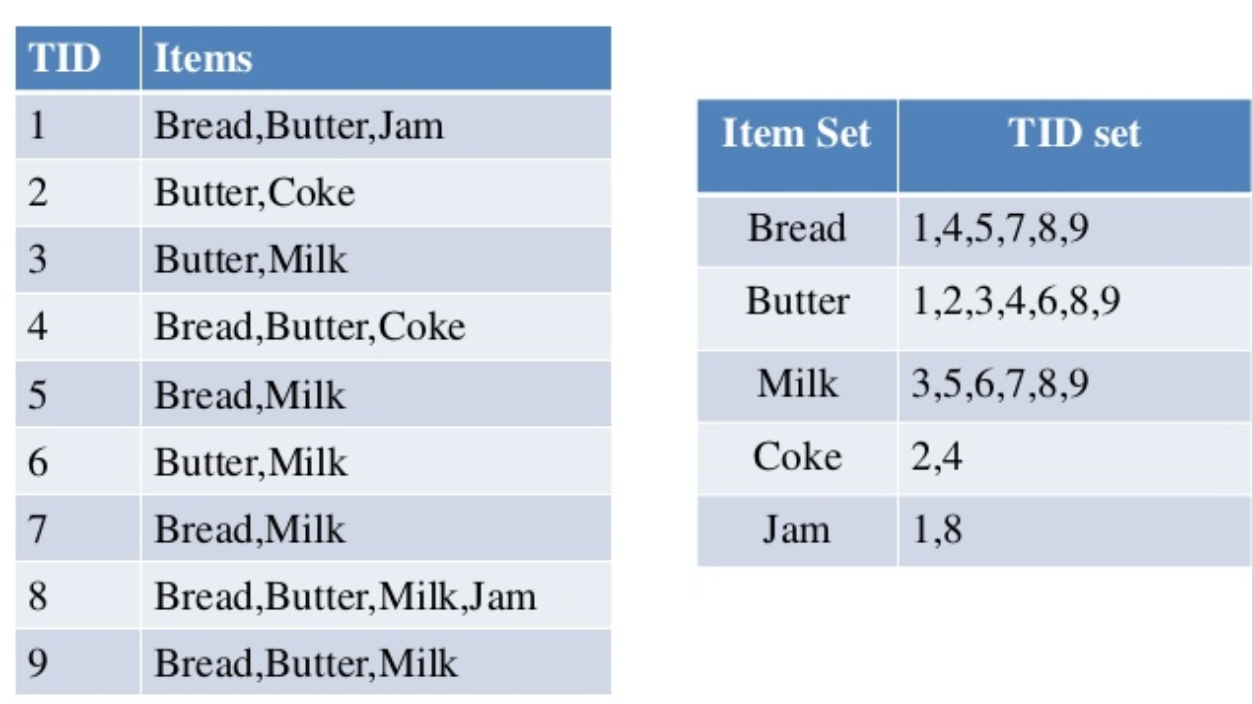

In [8]:
from IPython.display import Image
Image(filename='images/5.png', width=300, height=300)

**ECLAT algorithm**

1. Get tidlist for each item (DB scan) 
2. Tidlist of {a} is exactly the list of transactions containing {a} 
3. Intersect tidlist of {a} with the tidlists of all other items, resulting in tidlists of {a,b}, {a,c}, {a,d}, … = {a}-conditional database (if {a} removed) 
4. Repeat from 1 on {a}-conditional database 
5. Repeat for all other items

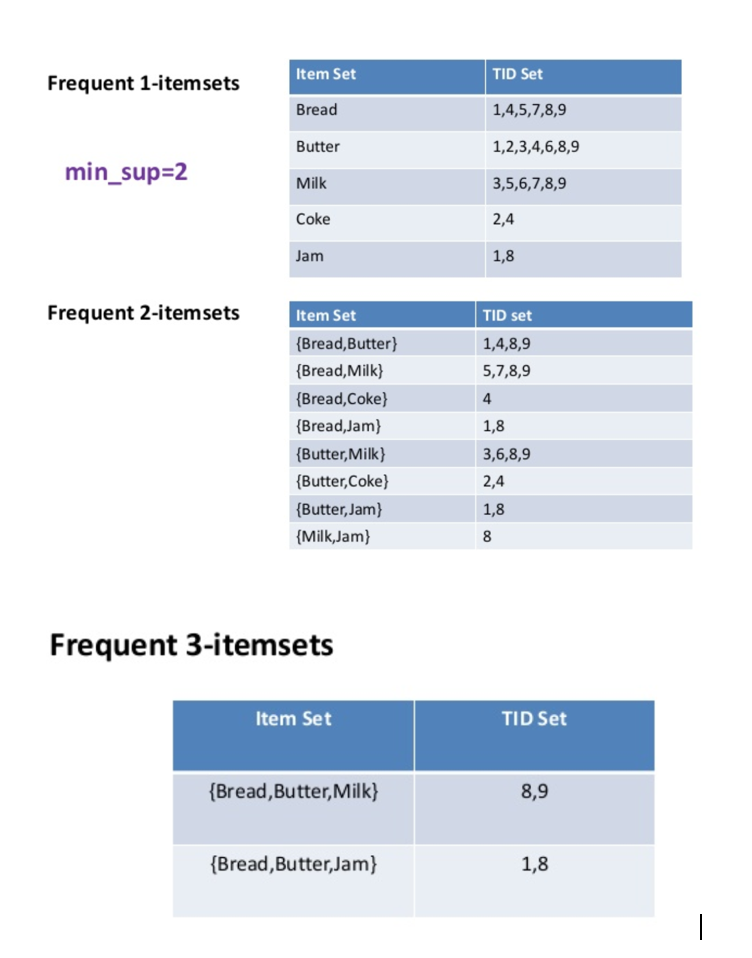

In [11]:
from IPython.display import Image
Image(filename='images/6.png', width=400, height=400)

This process repeats, with k incremented by 1 each time, until no frequent items or no candidate itemsets can be found. 

**ECLAT : Pros**

- Depth-first search reduces memory requirements.
- Usually (considerably) faster than Apriori, ECLAT is used to improve the efficiency of Apriori. 
- No need to scan the database to find the support of (k+1) itemsets, for k>=1.

**ECLAT : Cons**
- The TID-sets can be quite long, hence expensive to manipulate.

### Implementation

**Environment and Data Set up**

In [5]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Data Loading
dataset = pd.read_csv('Market_Basket_Optimisation.csv', header = None)

# Adding all customers into a list of lists
transactions = []
for i in range(0, 7501):
    transactions.append([str(dataset.values[i,j]) for j in range(0, 20)])

In [7]:
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Apriori implementation using apyori library

Using apriori algorithm, the below results reveal which are the products that used to be more bought in combination compared to other combinations.

In [8]:
# Inspecting elements
transactions[:2]

[['shrimp',
  'almonds',
  'avocado',
  'vegetables mix',
  'green grapes',
  'whole weat flour',
  'yams',
  'cottage cheese',
  'energy drink',
  'tomato juice',
  'low fat yogurt',
  'green tea',
  'honey',
  'salad',
  'mineral water',
  'salmon',
  'antioxydant juice',
  'frozen smoothie',
  'spinach',
  'olive oil'],
 ['burgers',
  'meatballs',
  'eggs',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan',
  'nan']]

To train the Apriori on the dataset, chosing below parameters.

- min_support = items bought more than 3 times a day * 7 days (week) / 7500 customers = 0.0028
- min_confidence: at least 20%, min_lift = minimum of 3 (less than that is too low)

In [9]:
from apyori import apriori
rules = apriori(transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2)

In [10]:
# Visualising the results
results = list(rules)

In [11]:
lift = []
association = []
for i in range (0, len(results)):
    lift.append(results[:len(results)][i][2][0][3])
    association.append(list(results[:len(results)][i][0]))

#### Visualizing results in a dataframe

In [12]:
rank = pd.DataFrame([association, lift]).T
rank.columns = ['Association', 'Lift']

In [13]:
# Show top 10 higher lift scores
rank.sort_values('Lift', ascending=False).head(10)

,Association,Lift
128,"[olive oil, whole wheat pasta, mineral water, ...",6.11586
58,"[olive oil, whole wheat pasta, mineral water]",6.11586
96,"[soup, mineral water, frozen vegetables, milk]",5.48441
146,"[soup, mineral water, frozen vegetables, nan, ...",5.48441
28,"[honey, fromage blanc, nan]",5.16427
3,"[honey, fromage blanc]",5.16427
16,"[chicken, nan, light cream]",4.84395
0,"[chicken, light cream]",4.84395
2,"[pasta, escalope]",4.70081
26,"[pasta, escalope, nan]",4.70081


The result reveals that, {"olive oil, whole wheat pasta, mineral water"} are the most commom combined items from this week for the supermarket.

### ECLAT Implementation

It calculate the pairs that have been bought more frequently comparing to other pairs. At the end, we expect to see what is the most common combination of products during the week.

An extension of the code can calculate the three most common combination, 4, and so on.

**Getting the list of products bought this week by all customers**

In [14]:
# Putting all transactions in a single list
itens = []
for i in range(0, len(transactions)):
    itens.extend(transactions[i])

# Finding unique items from transactions and removing nan
uniqueItems = list(set(itens))
uniqueItems.remove('nan')

**Creating combinations with the items - pairs**

In [15]:
pair = []
for j in range(0, len(uniqueItems)):
    k = 1;
    while k <= len(uniqueItems):
        try:
            pair.append([uniqueItems[j], uniqueItems[j+k]])
        except IndexError:
            pass
        k = k + 1;

#### Score Calculation

The calculation is done looking at the number of customers that bought both items (the pair) and divided by all customers of the week (7501). 
This calculation is done for all pairs possible and the score is returned on "score" list.

In [16]:
score = []
for i in pair:
    cond = []
    for item in i:
        cond.append('("%s") in s' %item)
    mycode = ('[s for s in transactions if ' + ' and '.join(cond) + ']')
    #mycode = "print 'hello world'"
    score.append(len(eval(mycode))/7501.)

#### Showing results

Top 10 Most common pairs of items of this week

In [17]:
ranking_ECLAT = pd.DataFrame([pair, score]).T
ranking_ECLAT.columns = ['Pair', 'Score']

In [18]:
ranking_ECLAT.sort_values('Score', ascending=False).head(10)

,Pair,Score
3809,"[spaghetti, mineral water]",0.0597254
6389,"[chocolate, mineral water]",0.0526596
7096,"[mineral water, eggs]",0.0509265
689,"[milk, mineral water]",0.0479936
6002,"[ground beef, mineral water]",0.0409279
3779,"[spaghetti, chocolate]",0.0391948
3770,"[spaghetti, ground beef]",0.0391948
3811,"[spaghetti, eggs]",0.0365285
6604,"[french fries, eggs]",0.0363951
1877,"[frozen vegetables, mineral water]",0.0357286


In [19]:
# Trying the same as above with trios
trio = []
for j in range(0, len(uniqueItems)):
    for k in range(j, len(uniqueItems)):
        for l in range(k, len(uniqueItems)):
            if (k != j) and (j != l) and (k != l):
                try:
                    trio.append([uniqueItems[j], uniqueItems[j+k], uniqueItems[j+l]])
                except IndexError:
                    pass

In [20]:
trio[:5]

[['pet food', 'green tea', 'whole wheat rice'],
 ['pet food', 'green tea', 'antioxydant juice'],
 ['pet food', 'green tea', 'chicken'],
 ['pet food', 'green tea', 'milk'],
 ['pet food', 'green tea', 'mint green tea']]

In [21]:
score_trio = []
for i in trio:
    cond = []
    for item in i:
        cond.append('("%s") in s' %item)
    mycode = ('[s for s in transactions if ' + ' and '.join(cond) + ']')
    score_trio.append(len(eval(mycode))/7501.)

In [22]:
ranking_ECLAT_trio = pd.DataFrame([trio, score_trio]).T
ranking_ECLAT_trio.columns = ['Trio', 'Score']
ranking_ECLAT_trio.sort_values('Score', ascending=False).head(10)

,Trio,Score
134586,"[spaghetti, chocolate, mineral water]",0.0158646
35350,"[milk, spaghetti, mineral water]",0.0157312
135293,"[spaghetti, mineral water, eggs]",0.0142648
37930,"[milk, chocolate, mineral water]",0.0139981
38637,"[milk, mineral water, eggs]",0.0130649
86786,"[frozen vegetables, spaghetti, mineral water]",0.0119984
37543,"[milk, ground beef, mineral water]",0.0110652
33418,"[milk, frozen vegetables, mineral water]",0.0110652
35320,"[milk, spaghetti, chocolate]",0.0109319
134588,"[spaghetti, chocolate, eggs]",0.0105319


### Comparing the results from Apriori and ECLAT

We got from Apriori that the combination that lead to more "attractiveness power" is {"olive oil", "whole wheat pasta" and "mineral water"}. 
If we run the ECLAT code for this set of items, we will obtain: 0.0039.

This score of 3 items has not enough score to be placed among top 10, but they are measuring different metrics. According to apriori these are the items that when picked one lead to another items more frequently than other combinations, i.e. when a person pick 'olive oil', the probability of picking 'whole wheat pasta' and 'mineral water' is much higher than picking another combination. ECLAT in another hand is just sorting as the most common combinations of all lists, not caring about how one item isolatedly can influence in the purchase of another.

In [23]:
i = ["olive oil", "whole wheat pasta", "mineral water"]
cond = []
for item in i:
    cond.append('("%s") in s' %item)
mycode = ('[s for s in transactions if ' + ' and '.join(cond) + ']')
#mycode = "print 'hello world'"
tra = eval(mycode)

In [24]:
print 'Score for "olive oil", "whole wheat pasta", "mineral water":', len(tra)/7501.

Score for "olive oil", "whole wheat pasta", "mineral water": 0.00386615117984


**References:**

https://github.com/amyoshino/Recommendation-System-with-Apriori-and-ECLAT/blob/master/Apriori_and_ECLAT.ipynb

http://mlwiki.org/index.php/Eclat

https://www.youtube.com/watch?v=oBiq8cMkTCU
    